In [14]:
from collections import defaultdict
import numpy as np
import scipy.stats
import torch
from torch.distributions import constraints
import matplotlib.pyplot as plt
%matplotlib inline

import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete

import pandas as pd


In [15]:
data = pd.read_csv('/mnt/d/mlpp/data/prices-split-adjusted.csv')

In [16]:
data['return'] = (data['close'] / data['open']) - 1

In [17]:
arr = data['return'].values

In [18]:
arr.shape

(851264,)

In [19]:
y = torch.from_numpy(arr)
# y = torch.unsqueeze(y,1)
y = y.type(torch.FloatTensor)

In [20]:
y.shape

torch.Size([851264])

## Trying with fixed number of components

In [21]:
n_comp = 10

In [22]:
# Reference: https://pyro.ai/examples/gmm.html
@config_enumerate
def model(data):
    # Global variables.
    weights = pyro.sample('weights', dist.Dirichlet(0.5 * torch.ones(n_comp)))
    scale = pyro.sample('scale', dist.LogNormal(0., 2.))
    with pyro.plate('components', n_comp):
        locs = pyro.sample('locs', dist.Normal(0.0004, 0.0002))

    with pyro.plate('data', len(data)):
        # Local variables.
        assignment = pyro.sample('assignment', dist.Categorical(weights))
        assignment.shape
        pyro.sample('obs', dist.Normal(locs[assignment], scale), obs=data)

# Using AutoDelta guide (MAP estimator)
global_guide = AutoDelta(poutine.block(model, expose=['weights', 'locs', 'scale']))

In [23]:
device = torch.device('cpu')

In [24]:
optim = pyro.optim.Adam({'lr': 0.1, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=1)
svi = SVI(model, global_guide, optim, loss=elbo)

In [25]:
# n_steps = 5000
# # do gradient steps
# for step in range(n_steps):
#     svi.step(y)

In [26]:
losses = []
for i in range(1000):
    loss = svi.step(y[:10000])
    losses.append(loss)
    print(loss)

366.840576171875
1248393.5
56766.20703125
295917.3125
578333.8125
270913.875
3844.8955078125
80164.015625
210679.859375
138850.015625
9602.07421875
6021.421875
69583.3828125
60439.359375
1413.3017578125
-10506.994140625
17458.703125
15954.962890625
-11092.50390625
-15747.3828125
-3330.556640625
-7270.8798828125
-19712.591796875
-18763.296875
-14363.33203125
-19508.689453125
-23746.1953125
-21392.712890625
-21725.66796875
-25084.095703125
-24975.939453125
-24162.90625
-25723.822265625
-26227.349609375
-25506.49609375
-25966.697265625
-26385.671875
-25961.96875
-26005.546875
-26298.814453125
-26139.015625
-26120.509765625
-26326.25390625
-26292.21484375
-26278.623046875
-26397.9296875
-26381.48046875
-26367.841796875
-26423.927734375
-26403.294921875
-26395.982421875
-26421.49609375
-26405.23828125
-26407.900390625
-26420.23046875
-26411.671875
-26418.892578125
-26423.33984375
-26419.85546875
-26425.58984375
-26425.140625
-26424.341796875
-26426.9296875
-26425.228515625
-26425.927734375


-26292.33984375
-26432.01171875
-26373.74609375
-26407.166015625
-26409.40625
-26424.650390625
-26444.5390625
-26430.1171875
-26444.326171875
-26432.970703125
-26437.482421875
-26433.666015625
-26395.572265625
-26320.931640625
-26123.984375
-25622.345703125
-24291.5546875
-20775.943359375
-12075.7607421875
5686.98828125
25547.1640625
18917.943359375
-14904.220703125
-22797.44921875
-6990.77734375
-11672.666015625
-25019.59375
-21464.6328125
-16471.66015625
-19449.064453125
-21276.763671875
-23561.0390625
-26038.822265625
-24608.875
-24407.98828125
-25988.68359375
-25407.328125
-26042.646484375
-26171.794921875
-25739.859375
-26239.318359375
-26058.62109375
-26243.46875
-26197.234375
-25875.529296875
-25433.3125
-24154.90625
-22111.57421875
-19850.876953125
-20615.33203125
-24700.58984375
-26384.2421875
-24697.01171875
-24142.30859375
-25789.552734375
-26379.38671875
-25542.05859375
-25548.033203125
-26285.09375
-26334.6953125
-25969.376953125
-26057.53515625
-26330.71875
-26236.4140625

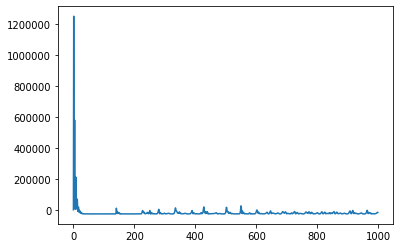

In [27]:
plt.plot(losses)

In [28]:
# Initializations
def initialize(seed):
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()
    # Initialize weights to uniform.
    pyro.param('auto_weights', 0.5 * torch.ones(n_comp), constraint=constraints.simplex)
    # Assume half of the data variance is due to intra-component noise.
    pyro.param('auto_scale', (y.var() / 2).sqrt(), constraint=constraints.positive)
    # Initialize means from a subsample of data.
    pyro.param('auto_locs', y[torch.multinomial(torch.ones(len(y)) / len(y), n_comp)]);
    loss = svi.loss(model, global_guide, y)
    return loss

# Choose the best among 100 random initializations.
loss, seed = min((initialize(seed), seed) for seed in range(100))
# initialize(seed)
print('seed = {}, initial_loss = {}'.format(seed, loss))

seed = 41, initial_loss = -2354894.0


In [31]:
gradient_norms = defaultdict(list)
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))

losses = []
for i in range(200):
    loss = svi.step(y)
    losses.append(loss)
    print('.' if i % 100 else '\n', end='')



...................................................................................................
...................................................................................................

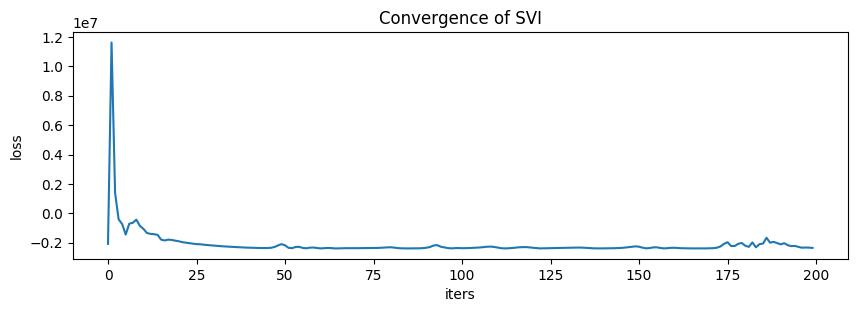

In [34]:
plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
# plt.yscale('log')
plt.title('Convergence of SVI');